# Iris multiclass classification problem

In [1]:
import sys
import os
import random
import csv
from pprint import pprint

from matplotlib import pyplot as plt

module_path = os.path.abspath(os.path.join("..", ".."))
sys.path.append(module_path)

from perceptron import Perceptron, cross_validation
from perceptron.data_utils import transpose, to_categorical


In [2]:
with open("iris.csv", "rt") as f:
    data = [
        [float(value) for value in features] + [target]
        for *features, target in [line for line in csv.reader(f) if line]
    ]

*features, targets = transpose(data)
features = transpose(features)
mapping, targets = to_categorical(targets)

print("Labels mapping:")
for label in mapping:
    print(label, mapping[label])


Labels mapping:
Iris-setosa [1, 0, 0]
Iris-versicolor [0, 1, 0]
Iris-virginica [0, 0, 1]


# Single layer model

Training: 100% |████████████████████████████████████████| 20/20, categorical_accuracy=0.98, mse=0.0122


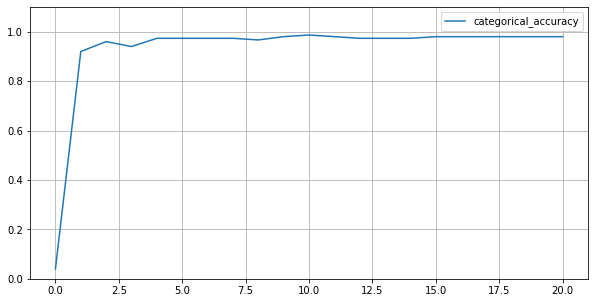

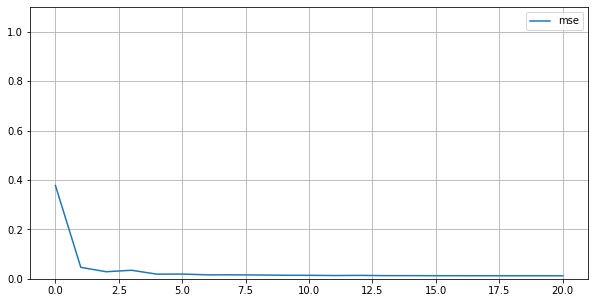

In [3]:
random.seed(0)

model = Perceptron(
    inputs=4,
    layer_sizes=[3],
    activations="softmax",
    init_method="he",
    normalization="zscore",
    optimizer="adam",
)

epochs = 20

history = model.train(
    training_inputs=features,
    training_targets=targets,
    epochs=epochs,
    batch_size=4,
    base_learning_rate=0.1,
    learning_rate_decay="linear",
    metrics=["categorical_accuracy", "mse"],
)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

ax.plot(
    range(epochs + 1), history["categorical_accuracy"], label="categorical_accuracy"
)

ax.set_ylim(bottom=0, top=1.1)
ax.grid()
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

ax.plot(range(epochs + 1), history["mse"], label="mse")

ax.set_ylim(bottom=0, top=1.1)
ax.grid()
ax.legend()
plt.show()


# Multi-layer model

Training: 100% |████████████████████████████████████████| 20/20, categorical_accuracy=0.973, mse=0.0106


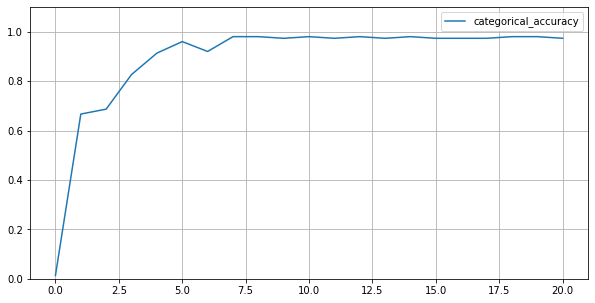

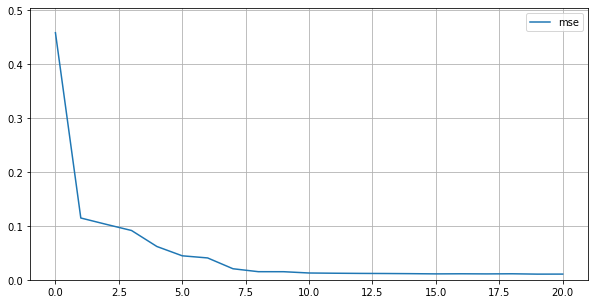

In [4]:
random.seed(0)

model = Perceptron(
    inputs=4,
    layer_sizes=[4, 3, 3],
    activations=["leaky_relu"] * 2 + ["softmax"],
    init_method="he",
    normalization="zscore",
    optimizer="adam",
)

epochs = 20

history = model.train(
    training_inputs=features,
    training_targets=targets,
    epochs=epochs,
    batch_size=8,
    base_learning_rate=0.1,
    learning_rate_decay="linear",
    metrics=["categorical_accuracy", "mse"],
)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

ax.plot(
    range(epochs + 1), history["categorical_accuracy"], label="categorical_accuracy"
)

ax.set_ylim(bottom=0, top=1.1)
ax.grid()
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

ax.plot(range(epochs + 1), history["mse"], label="mse")

ax.set_ylim(bottom=0, top=max(history["mse"]) * 1.1)
ax.grid()
ax.legend()
plt.show()


# Cross validating multi-layer model

In [5]:
random.seed(0)

model_params = dict(
    inputs=4,
    layer_sizes=[4, 3, 3],
    activations=["leaky_relu"] * 2 + ["softmax"],
    init_method="he",
    normalization="zscore",
    optimizer="adam",
)

epochs = 20

history = cross_validation(
    inputs=features,
    targets=targets,
    fold_count=3,
    epoch=epochs,
    batch_size=4,
    base_learning_rate=0.1,
    learning_rate_decay="linear",
    model_params=model_params,
    metrics=["categorical_accuracy", "mse"],
)


Training: 100% |████████████████████████████████████████| 20/20, categorical_accuracy=0.99, mse=0.00524, val_categorical_accuracy=0.96, val_mse=0.0183
Training: 100% |████████████████████████████████████████| 20/20, categorical_accuracy=0.99, mse=0.00542, val_categorical_accuracy=0.94, val_mse=0.0248
Training: 100% |████████████████████████████████████████| 20/20, categorical_accuracy=0.97, mse=0.0115, val_categorical_accuracy=0.98, val_mse=0.0147 


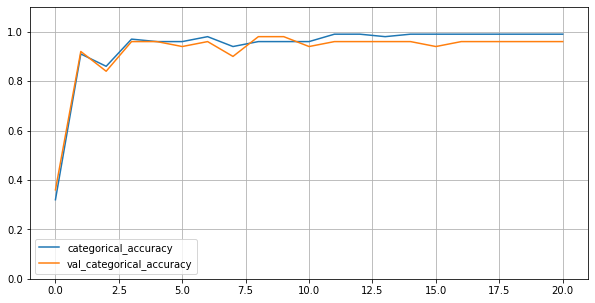

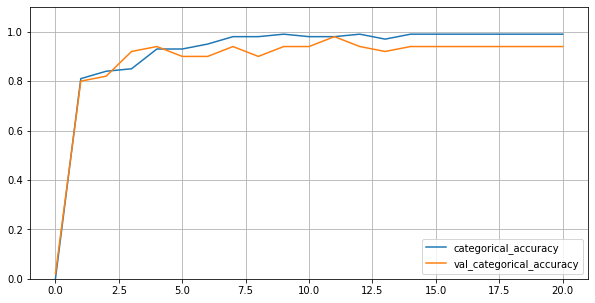

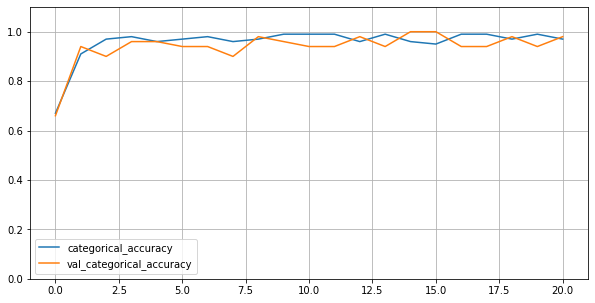

In [6]:
for run in history:
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot()

    for metric in ["categorical_accuracy", "val_categorical_accuracy"]:
        ax.plot(range(epochs + 1), run[metric], label=metric)

    ax.set_ylim(bottom=0, top=1.1)
    ax.grid()
    ax.legend()
    plt.show()
